In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.transforms import ScaledTranslation
from matplotlib import rc
import sys
import sciris as sc
sys.path.append('../../')
from fig1_calibration import create_sim as cs
bounds = cs.define_pars(which='bounds',use_safegraph=True)
bounds['tn'][0] = 5.0
rc('font', **{'family': 'serif', 'serif': ['Times']})
rc('text', usetex=False)
rc('grid', linestyle="--", color='black')

# wave colors
colors ={0:'#374E55FF',
        1:'#DF8F44FF',
        2:'#00A1D5FF',
        3:'#B24745FF',
        4:'#79AF97FF',
        'ABC':'#6A6599FF'}
wave_labels = {0:'Wave 0',4:'Wave 4','ABC':'ABC'}

df_initial = pd.read_csv('../2024-07-03-sims_combined-tn-5.csv')
df_initial['wave'] = 0
df_sims    = pd.concat([
    pd.read_csv('../data/sims_combined-wave001.csv').assign(wave=1),
    pd.read_csv('../data/sims_combined-wave002.csv').assign(wave=2),
    pd.read_csv('../data/sims_combined-wave003.csv').assign(wave=3),
    pd.read_csv('../data/sims_combined-wave004.csv').assign(wave=4)
])
posterior = pd.read_csv('../data/sims_combined-posterior.csv').assign(wave='ABC')

df = pd.concat(
    [df_initial,
     df_sims,
     posterior
    ]
)

keys = ['beta', 'bc_lf', 'tn', 'bc_wc1']
mapping = sc.objdict({
    'beta'  : r'Overall $\beta$',
    'bc_wc1': r'Work/community $\beta$ reduction',
    'bc_lf' : r'LTCF $\beta$ reduction',
    'tn'   : 'Symptomatic testing OR',
    })

Covasim 2.1.2 (2021-03-31) — © 2021 by IDM


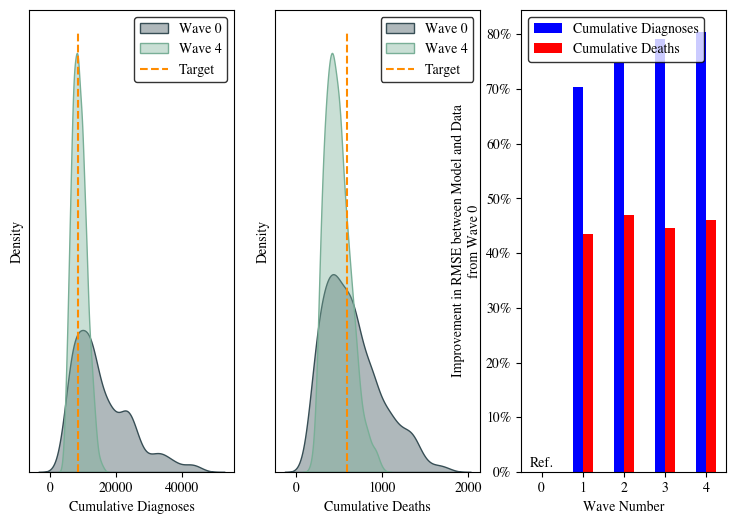

In [2]:
# wave output of cumulative diagnoses compared to data
import matplotlib.pyplot as plt
import seaborn as sns


outputs = ['cum_diagnoses','cum_deaths']
output_mapping = {
    'cum_diagnoses':'Cumulative Diagnoses',
    'cum_deaths': 'Cumulative Deaths'
}
tmax = df['t'].max()
df_last_tick = df.query('t==@tmax').copy()
df_last_tick['wave_num'] = [f'Wave {num}' for num in df_last_tick['wave'].values]

waves_to_plot = [0,4] # 0, 4, ABC
df_first_last = df_last_tick.query('wave==@waves_to_plot').copy()
include_post = 'ABC' in waves_to_plot
def compare_wave_outputs(fig=None,ax=None,ax_iter = None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(ncols=3,figsize=(9,6))
        ax_iter = [0,1,2]
    # part one: performance of first and last waves
    for ii, output in enumerate(outputs):
        i = ax_iter[ii]
        empirical = df_first_last[f'{output}_data'].unique()
        # densities
        sns.kdeplot(
            x=output,data=df_first_last.query('wave==0'),
            color = colors[0],label = 'Wave 0',
            ax=ax[i],fill=True,alpha=0.4
        )
        sns.kdeplot(
            x=output,data=df_first_last.query('wave==4'),
            color = colors[4],label = 'Wave 4',
            ax=ax[i],fill=True,alpha=0.4
        )
        
        if include_post:
            sns.kdeplot(
            x=output,data=df_first_last.query('wave=="ABC"'),
            color = colors['ABC'],label = 'ABC',
            ax=ax[i],fill=True,alpha=0.4
        )
        # verical line
        yl, yu = ax[i].get_ylim()
        ax[i].vlines(x=empirical,ymin=yl,ymax=yu,
        linestyles='dashed',color='darkorange',label='Target')
        # remove y density
        ax[i].set_yticks([])
        ax[i].yaxis.set_tick_params(labelcolor='none')
        ax[i].set_xlabel(output_mapping[output])
        #handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(edgecolor='black')
    # part two: % improvement across waves
    # mean-squared error
    mse_keys = []
    for output in outputs:
        mse_key = f"mse_{output}"
        mse_keys.append(mse_key)
        data_key = f"{output}_data"
        df_last_tick[mse_key] = ((df_last_tick[output] - df_last_tick[data_key])**2)

   
    bar_data = (df_last_tick.groupby('wave')[mse_keys].mean()**0.5).copy().reset_index()
    if include_post==False:
        bar_data = bar_data.query('wave!="ABC"')
    bar_data[['mse_cum_diagnoses_perc','mse_cum_deaths_perc']] =  -100*((bar_data[mse_keys].values/bar_data.query('wave==0')[mse_keys].values) - 1)
    bar_data.plot.bar(
        x='wave',y=['mse_cum_diagnoses_perc','mse_cum_deaths_perc'],
        label=['Cumulative Diagnoses','Cumulative Deaths'],
        color=['blue','red'],
        rot=0,
        xlabel='Wave Number',
        ylabel='Improvement in RMSE between Model and Data\nfrom Wave 0',
        ax=ax[ax_iter[-1]]
    )
    ax[ax_iter[-1]].text(x=0,y=1,s="Ref.",horizontalalignment='center')
    ax[ax_iter[-1]].yaxis.set_major_formatter(ticker.PercentFormatter(100))
    ax[ax_iter[-1]].legend(edgecolor='black',loc='upper left')
    return fig, ax
compare_wave_outputs();

In [3]:
# emulator output
from hetgpy import hetGP
import pickle
import os
from scipy.stats import qmc

with open('../emulators/hetGPy-iter_000.pkl','rb') as stream:
    emulator_wave0_raw = pickle.load(stream)
    emulator_wave0 = {}
    # rename keys
    emulator_wave0['cum_diagnoses'] = emulator_wave0_raw['cum_diagnoses_133']
    emulator_wave0['cum_deaths'] = emulator_wave0_raw['cum_deaths_133']
# need to train emulator for wave 4
em4_path = '../emulators/hetGPy-iter_004.pkl'
if os.path.exists(em4_path):
    with open(em4_path,'rb') as stream:
        emulator_wave4 = pickle.load(stream)
else:
    # train
    emulator_wave4 = {}
    df_last_wave = df_last_tick.query('wave_num=="Wave 4"')
    X = df_last_wave[keys].values
    Xsc = qmc.scale(X,
        l_bounds=[bounds[k][0] for k in keys],
        u_bounds=[bounds[k][1] for k in keys],
        reverse=True
    )
    for output in ['cum_diagnoses','cum_deaths']:
        em = hetGP()
        em.mle(
            X = Xsc,
            Z = df_last_wave[output].values,
            covtype="Matern5_2",
            lower = [0.1 for i in range(X.shape[1])],
            upper = [10 for i in range(X.shape[1])],
            maxit = 1000,
            settings = {'checkHom':True}
        )
        emulator_wave4[output] = em
    with open(em4_path,'wb') as stream:
        pickle.dump(emulator_wave4,stream)
    

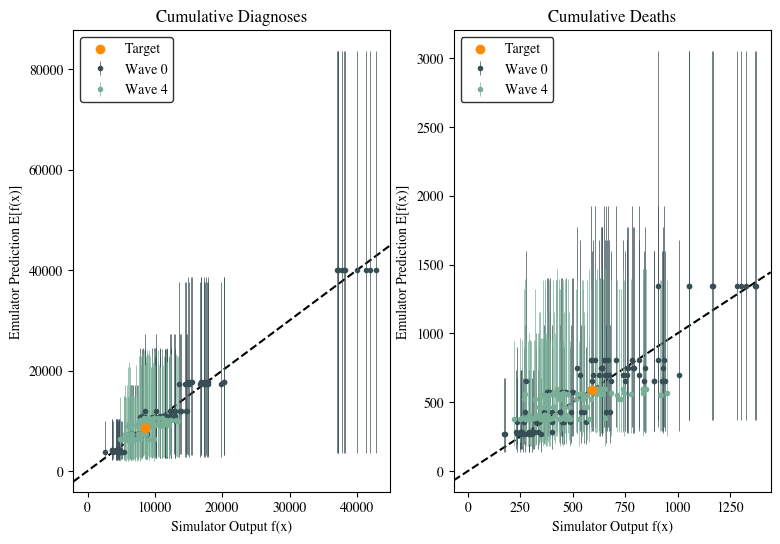

In [4]:
# get validation data
validation_data = pd.concat(
    [pd.read_csv('../data/sims_combined-validation.csv'),
     pd.read_csv('../data/sims_combined-posterior.csv').assign(wave='ABC')
     ])
tmax = validation_data['t'].max()
validation_data_last_tick = validation_data.query('t==@tmax').copy()

def compare_simulator_to_emulator(fig=None,ax=None,ax_iter=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(ncols=2,figsize=(9,6))
        ax_iter = [0,1]
    outputs = ['cum_diagnoses','cum_deaths']
    ems = {0:emulator_wave0,4:emulator_wave4,'ABC':emulator_wave4}
    for ii, output in enumerate(outputs):
        i = ax_iter[ii]
        for j, wave in enumerate(waves_to_plot):
            em = ems[wave]
            df_wave = validation_data_last_tick.query('wave==@wave').copy()
            Xp = qmc.scale(df_wave[keys].values,
                    l_bounds=[bounds[k][0] for k in keys],
                    u_bounds=[bounds[k][1] for k in keys],
                    reverse=True
            )
            simulator_outputs = df_wave[output].values
            emulator_outputs  = em[output].predict(
                Xp,interval='predictive',
                interval_lower=0.025,interval_upper=0.975
            )
            ax[i].errorbar(
                simulator_outputs,
                emulator_outputs['mean'],
                yerr = np.vstack([
                    emulator_outputs['predictive_interval']['lower'],
                    emulator_outputs['predictive_interval']['upper']
                ]
                ),
                fmt='.',
                color=colors[wave],
                elinewidth=0.5,
                label=wave_labels[wave],
                zorder=500
            )
        # plot target
        target = df_last_tick[f"{output}_data"].unique()
        ax[i].scatter(target,target,label='Target',color='darkorange',zorder=1000)
        ax[i].legend(edgecolor='black',loc='upper left')
        ax[i].axline((0,0),slope=1,color='black',linestyle='dashed');
        ax[i].set_ylabel('Emulator Prediction E[f(x)]')
        ax[i].set_xlabel('Simulator Output f(x)')
        ax[i].set_title(output_mapping[output])
    return fig, ax
fig, ax = compare_simulator_to_emulator()

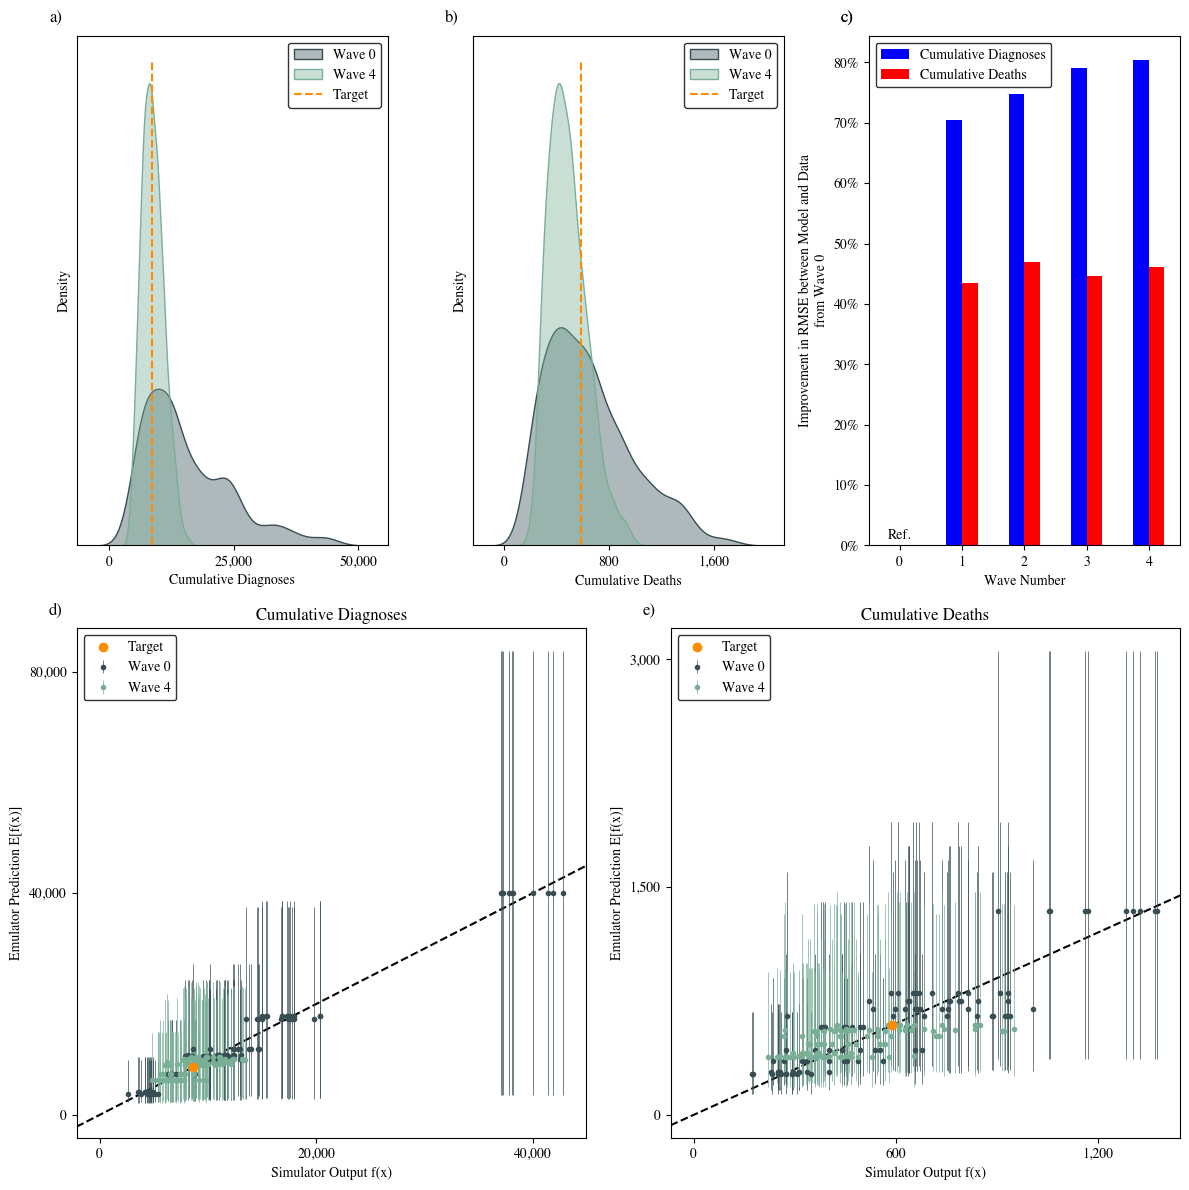

In [5]:
# plot the whole thing
pattern = '''
aabbcc
dddeee
'''
fig, ax = plt.subplot_mosaic(pattern,figsize=(12,12))

fig, ax = compare_wave_outputs(fig=fig,ax=ax,ax_iter=['a','b','c'])
fig, ax = compare_simulator_to_emulator(fig=fig,ax=ax,ax_iter=['d','e'])

def add_fig_labels(position,label):
    ax[position].text(
        0.0, 1.0, label, transform=(
            ax[position].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')
def format_ax(ax,format_y=False,format_x=False):
    ''' Format the axes nicely '''
    if format_y:
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if format_x:
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    return

# format
format_ax(ax['a'],format_x=True)
format_ax(ax['b'],format_x=True)
format_ax(ax['d'],format_y=True,format_x=True)
format_ax(ax['e'],format_y=True,format_x=True)

# label
add_fig_labels('a','a)')
add_fig_labels('b','b)')
add_fig_labels('c','c)')
add_fig_labels('c','c)')
add_fig_labels('d','d)')
add_fig_labels('e','e)')
fig.tight_layout()
fig.savefig('../response-figs/01-simulator-emulator.pdf')

In [6]:
# stats for paper
(df.query('t==@tmax').groupby('wave')
[['cum_deaths','cum_diagnoses']]
.describe(percentiles=[0.025,0.5,0.975]))

cum_deaths                                                              \
          count        mean         std         min        2.5%         50%   
wave                                                                          
0        1250.0  649.472721  331.328731  105.804161  193.186139  591.382921   
1        1000.0  500.786635  167.932448  171.494751  254.842365  469.384590   
2        1000.0  519.810051  164.410369  181.240595  277.628260  495.207585   
3        1000.0  480.513321  150.877272  182.053176  262.716811  454.860413   
4        1000.0  483.110022  146.843692  187.895635  266.059112  461.822493   
ABC        50.0  631.995583  142.518282  365.207646  412.079448  634.213007   

                               cum_diagnoses                             \
            97.5%          max         count          mean          std   
wave                                                                      
0     1400.990419  1790.082292        1250.0  15618.708784  8814.469891   
1      893.924987  1121.311130        1000.0  10180.348782  2938.026446   
2      897.328127  1202.869999        1000.0   9995.649714  2484.496197   
3      832.940843  1130.202808        1000.0   8912.920939  2341.924369   
4      828.242609  1000.387252        1000.0   8752.682886  2203.958402   
ABC    859.367836   934.275959          50.0   9554.852034  1308.641504   

                                                                          
              min         2.5%           50%         97.5%           max  
wave                                                                      
0     2730.958084  5050.548109  13040.768322  38002.376596  46768.736604  
1     3804.594178  4973.775669  10062.735197  15897.517611  18951.239252  
2     3901.288674  5553.313422   9821.920324  15324.295724  18100.160797  
3     4256.986223  5110.204234   8700.223098  13959.253212  17394.289194  
4     4075.923775  5028.031262   8512.901144  13486.820411  16290.345044  
ABC   6203.215337  6564.810482   9484.552514  11434.336044  12493.138991

In [7]:
# data
df.query('t==@tmax')[['cum_diagnoses_data','cum_deaths_data']].drop_duplicates(keep='first')

,cum_diagnoses_data,cum_deaths_data
133,8595.0,590.0


In [8]:
# averge distance between design points over model runs
from scipy.spatial.distance import pdist
from scipy.spatial import ConvexHull
designs = df[keys + ['wave']].drop_duplicates(keep='first').copy()
# scale
designs[keys] = qmc.scale(
    designs[keys].values,
    l_bounds = [bounds[k][0] for k in keys],
    u_bounds = [bounds[k][1] for k in keys],
    reverse=True)
pairwise_dists = []
for wave in designs['wave'].unique():
    d = {}
    d['wave'] = wave
    X = designs.query('wave==@wave').copy()[keys].values
    hull = ConvexHull(X)
    dists = pdist(X,metric='euclidean').mean()
    d['dists'] = dists
    d['volume'] = hull.volume
    pairwise_dists.append(d)
pairwise_dists = pd.DataFrame(pairwise_dists)
pairwise_dists


,wave,dists,volume
0,0,0.786763,0.337610
1,1,0.805206,0.041727
2,2,0.741328,0.023750
3,3,0.624993,0.013375
4,4,0.574455,0.005457
5,ABC,0.192466,0.000002
